In [1]:
import os
import regex
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from transformers import pipeline

/home/coder/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-26 13:16:35.998800: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
filename = os.path.join(
    "..", 
    "in",  
    "fake_or_real_news.csv")

In [3]:
data = pd.read_csv(
    filename, 
    index_col = 0)

In [4]:
data = data.reset_index(drop = True) # fix index

In [5]:
headlines = data["title"]

In [6]:
classifier = pipeline(
    "text-classification", 
    model = "j-hartmann/emotion-english-distilroberta-base", 
    return_all_scores = True)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
/home/coder/.local/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [7]:
def extract_emotions(score_list):
    emotion = str([max(score, key = lambda x:x['score'])['label'] for score in score_list])
    likelihood = str([max(score, key = lambda x:x['score'])['score'] for score in score_list])

    emotion = regex.sub('\[*\'\]*', '', emotion)
    likelihood = float(regex.sub('\[*\]*', '', likelihood))

    return emotion, likelihood

In [8]:
def classifier_output(texts, classifier):

    # initialize empty lists
    emotions_list = list()
    likelihoods_list = list()

    # loop through all the texts
    for i in range(0, len(texts)):
        text = texts.iloc[i]
        score_list = classifier(text)

        emotion, likelihood = extract_emotions(score_list)

        emotions_list.append(emotion)
        likelihoods_list.append(likelihood)
    
    return emotions_list, likelihoods_list

In [10]:
emotions, likelihoods = classifier_output(headlines, classifier)

In [11]:
emotions = pd.Series(emotions)

In [12]:
likelihoods = pd.Series(likelihoods)

In [13]:
data['emotions'] = emotions

In [14]:
data['likelihoods'] = likelihoods

In [15]:
together = pd.DataFrame(data.groupby(['emotions']).size().reset_index(name = 'counts'))

In [16]:
together = together.set_index('emotions')
total_count = together['counts'].sum()
together['proportion'] = together['counts'] / total_count
    

In [18]:
t1_path = os.path.join(
    "..", 
    "out", 
    "all_table.csv")
together.to_csv(
    t1_path, 
    index = False)

/tmp/ipykernel_32000/4081548134.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('PiYG'))


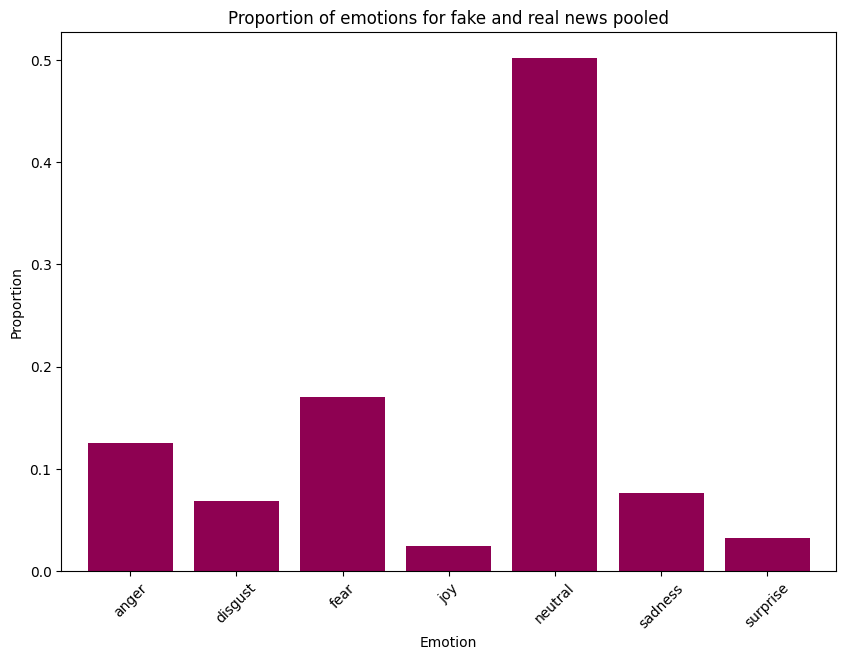

In [19]:
fig = together.plot(
    figsize = (10, 7),
    y = 'proportion',
    kind = 'bar', 
    width = 0.8, 
    legend = None,
    colormap = cm.get_cmap('PiYG'))

fig.set_xlabel('Emotion')
fig.set_ylabel('Proportion')
fig.set_xticklabels(
    together.index, 
    rotation = 45) # rotate x-axis labels by 45 degrees
plt.title('Proportion of emotions for fake and real news pooled')

plt.savefig(os.path.join(
    "..", 
    "out", 
    "all_plot.jpg"))
 
# Show Plot
plt.show()

In [20]:
separate = data.groupby(['emotions', 'label']).size().reset_index(name = 'counts')

In [21]:
sep_pivoted = separate.pivot(
    columns = 'label', 
    values = 'counts', 
    index = 'emotions')

In [22]:
total_count_fake = sep_pivoted['FAKE'].sum()
total_count_real = sep_pivoted['REAL'].sum()
sep_pivoted['proportion_fake'] = sep_pivoted['FAKE'] / total_count_fake
sep_pivoted['proportion_real'] = sep_pivoted['REAL'] / total_count_real

In [23]:
subset = sep_pivoted[['proportion_fake', 'proportion_real']]

In [25]:
t2_path = os.path.join(
    "..", 
    "out", 
    "separate_table.csv")
subset.to_csv(
    t2_path, 
    index = False)

/tmp/ipykernel_32000/2884522224.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('PiYG'))


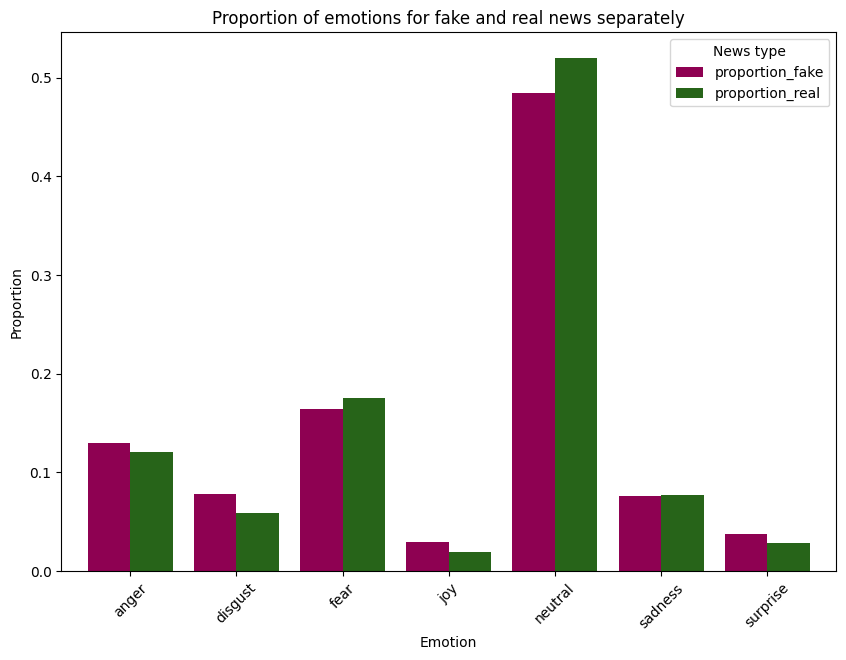

In [26]:
fig2 = subset.plot(
    figsize = (10, 7),
    kind = 'bar', 
    width = 0.8, 
    colormap = cm.get_cmap('PiYG'))
fig2.set_xlabel('Emotion')
fig2.set_ylabel('Proportion')
fig2.set_xticklabels(
    subset.index, 
    rotation=45) # rotate x-axis labels by 45 degrees
fig2.legend(title = 'News type') # set legend title
plt.title('Proportion of emotions for fake and real news separately')
plt.savefig(os.path.join(
    "..", 
    "out", 
    "separate_plot.jpg"))
plt.show()

In [ ]:
# proportion data?

In [144]:
def extract_emotions(score_list):
    
    emotions = max(score_list[0], key = lambda x:x['score'])
    emotion = emotions['label']
    likelihood = emotions['score']

    return emotion, likelihood

In [145]:
def classifier_output(texts):

    # initialize empty lists
    emotions_list = list()
    likelihoods_list = list()

    # loop through all the texts
    for i in range(0, len(texts)):

        # run classifier on each text
        text = texts.iloc[i]
        score_list = classifier(text)
        
        # extract most likely emotion
        emotion, likelihood = extract_emotions(score_list)

        # append to prepared list
        emotions_list.append(emotion)
        likelihoods_list.append(likelihood)

    emotions_series = pd.Series(emotions_list)
    likelihoods_series = pd.Series(likelihoods_list)
    
    return emotions_series, likelihoods_series

In [146]:
emotions, likelihoods = classifier_output(headlines)